In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

def plot_importances(df_importances, save=None, xrot=0, tickstep=3):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.
    """
    I = df_importances

    fig = plt.figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w, h*.5, forward=True)
    ax = plt.gca()
    ax.barh(np.arange(len(I.index)), I.Importance, height=.7, tick_label=I.index)

    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect((x1 - x0) / (y1 - y0))

    # rotate x-ticks
    if xrot is not None:
        plt.xticks(rotation=xrot)

    # xticks freq
    xticks = ax.get_xticks()
    nticks = len(xticks)
    new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
    ax.set_xticks(new_ticks)

    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
    plt.show()

In [4]:
df = pd.read_csv("data/rent.csv")
features = ['bathrooms','bedrooms','longitude','latitude',
            'price']
df = df[features].copy()
df['price'] = np.log(df['price'])
df.head(5)

,bathrooms,bedrooms,longitude,latitude,price
0,1.5,3,-73.9425,40.7145,8.006368
1,1.0,2,-73.9667,40.7947,8.606119
2,1.0,1,-74.0018,40.7388,7.955074
3,1.0,1,-73.9677,40.7539,8.094073
4,1.0,4,-73.9493,40.8241,8.116716


# Built-in scikit importances

0.876642769789


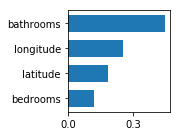

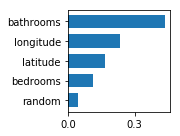

In [5]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True)

X_train, y_train = df.drop('price',axis=1), df['price']
rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)

I = mkdf(X_train.columns,rf.feature_importances_)            
plot_importances(I, save='../article/images/regr_dflt.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
I = mkdf(X_train2.columns,rf2.feature_importances_)
plot_importances(I, save='../article/images/regr_dflt_random.svg')

## Examine cost of dropping columns

In [8]:
from sklearn.base import clone

# max_features=n_features for regressors but sqrt for classifiers

def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    return np.array(imp)

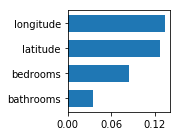

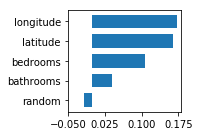

In [19]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

X_train, y_train = df.drop('price',axis=1), df['price']
rf = clone(base_rf)

imp = dropcol_importances(rf, X_train, y_train)
I = mkdf(X_train.columns,imp)
plot_importances(I, save='../article/images/regr_dropcol.svg')

X_train, y_train = df.drop('price',axis=1), df['price']
X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
imp = dropcol_importances(rf2, X_train2, y_train)
I = mkdf(X_train2.columns,imp)
plot_importances(I, save='../article/images/regr_dropcol_random.svg')

# Roll your own OOB R^2 score

In [15]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import r2_score
import warnings

# TODO: add arg for subsample size to compute oob score

def oob_regression_r2_score(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions
    
    oob_score = r2_score(y, predictions)
    return oob_score

# Permutation importance

In [11]:
def permutation_importances(rf, X_train, y_train, metric):
    """
    Return importances from pre-fit rf; this function
    works for regressors and classifiers. The metric
    arg is function that measures accuracy or R^2 or
    similar; it should use the out-of-bag samples from
    training set.
    """
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

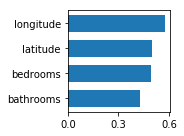

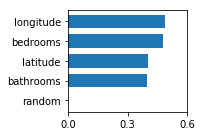

In [18]:
X_train, y_train = df.drop('price',axis=1), df['price']

base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                max_features=len(X_train.columns),
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

rf = clone(base_rf)
rf.fit(X_train, y_train)

imp = permutation_importances(rf, X_train, y_train,
                              oob_regression_r2_score)
I = mkdf(X_train.columns,imp)
plot_importances(I, save='../article/images/regr_permute.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)

imp = permutation_importances(rf2, X_train2, y_train,
                              oob_regression_r2_score)
I = mkdf(X_train2.columns,imp)
plot_importances(I, save='../article/images/regr_permute_random.svg')